<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/legislative_branch_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# I want to create a kpi dashboard for candidates that are running again for the same office

# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl squarify wordcloud

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build
import squarify
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Pull Data

In [2]:
# ################################################### #
# ####### pull in the data for the candidates ####### #
# ################################################### #

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'cleaned_candidates_data.csv'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_csv(file_path+filename)

# There are 2 types of candidates running for office in the legislative branch
# Those that have been in office and are running again (incumbent)
# And those who are running to be in office the first time.
# Let's just look at the incumbents and see what legislation they've sponsored and whether it's passed or not passed

# don't need all the info right now
include_columns = ['Name on Ballot', 'First Name', 'Middle Name',
                   'Last Name', 'Office', 'District', 'Party',
                   'Status','Display District', 'record_id', 'Incumbent']
candidates = candidates[include_columns].copy()

# only need candidates that are running again
include_status = ['Election Candidate', 'Write-In']
candidates = candidates.loc[candidates['Status'].isin(include_status)].copy().reset_index(drop=True)

# only look at incumbent candidates
candidates = candidates.loc[candidates['Incumbent'] == True].copy().reset_index(drop=True)
# only look at State House & State Senate
candidates = candidates.loc[candidates['Office'].isin(['State House', 'State Senate'])].copy().reset_index(drop=True)


Mounted at /content/drive
Reading Excel file...


In [3]:
# #################################################################### #
# ####### pull in the data for the bills that have been passed ####### #
# #################################################################### #

bills_file_path = '/content/drive/My Drive/ut_pol/passedBills/'

list_of_bills = os.listdir(bills_file_path)
# print(list_of_bills)

all_data = []

for f in list_of_bills:
  if f.endswith('.csv'):
    temp = pd.read_csv(bills_file_path + f)
    temp['sheet_name'] = f
    all_data.append(temp)

bills = pd.concat(all_data, axis=0, ignore_index=True)

# print(bills.head())

# we only need data for 2021 - 2024
bills['Year'] = bills['sheet_name'].str.extract(r'(\d{4})')
bills = bills.loc[bills['Year'].isin(['2021', '2022', '2023', '2024'])].copy().reset_index(drop=True)

# make sure dtypes are correct
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Effective Date'] = pd.to_datetime(bills['Effective Date'], errors='coerce')
bills['Gov\'s Action Date'] = pd.to_datetime(bills['Gov\'s Action Date'], errors='coerce')
bills['Year'] = bills['Year'].astype(int)

# What to do when the gov's action is empty

bills['Governor\'s Action'].unique()

bills.loc[bills['Governor\'s Action'].isnull()]

# Replace null values in the 'Governor's Action' column with 'no value'
bills['Governor\'s Action'] = bills['Governor\'s Action'].fillna('NO VALUE').copy().reset_index(drop=True)

# Merge Data

In [4]:
# 1st merge the two dataframes together
# Extracting last name and first initial from Bill Sponsor in the bills dataframe
bills['Last Name'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[0])
bills['First Initial'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[1][0] if len(x.split(', ')) > 1 else '')

# Create a column to match with candidates by concatenating Last Name and First Initial
bills['Sponsor Key'] = bills['Last Name'] + ' ' + bills['First Initial']

# In the candidates dataframe, create a key column to match with bills
candidates['First Initial'] = candidates['First Name'].str[0]  # Get the first initial
candidates['Candidate Key'] = candidates['Last Name'] + ' ' + candidates['First Initial']

merged_df = pd.merge(candidates, bills, left_on='Candidate Key', right_on='Sponsor Key', how='left')


In [5]:
# Which candidates sponsored no bills?

print(merged_df.loc[merged_df['Bill Number'].isna()]['Name on Ballot'].unique())

['MATT MACPHERSON']


# Create Categories

In [6]:
# Categories targeting keywords in the bills.

categories = {
    'Education': ['higher education',
                  'juvenile',
                  'school',
                  'university',
                  'student',
                  'education',
                  'students',
                  'teacher',
                  'educator',
                  'learning',
                  'academic',
                  'college',
                  'preschool',
                  'daycare',
                  'scholarship',
                  'training',
                  'literacy',
                  'diploma',
                  'certification',
                  'tutoring',
                  'virtual learning',
                  'STEM',
                  'vocational'],
    'Healthcare': ['health',
                   'medical',
                   'hospital',
                   'healthcare',
                   'wellness',
                   'doctor',
                   'nurse',
                   'patient',
                   'mental health',
                   'therapy',
                   'pharmacy',
                   'perscription',
                   'medication',
                   'vaccination',
                   'clinic',
                   'public health',
                   'emergency care',
                   'Medicare',
                   'Medicaid',
                   'telehealth',
                   'nutrition',
                   'fitness',
                   'insurance',
                   'coverage',
                   'healthcare plan',
                   'health policy',
                   'ACA',
                   'Affordable Care Act'],
    'Environment': ['wildlife',
                    'conservation',
                    'climate',
                    'public lands',
                    'water',
                    'land',
                    'energy',
                    'federal lands',
                    'national parks',
                    'parks',
                    'air pollution',
                    'pollution',
                    'sustainability',
                    'renewable energy',
                    'solar energy',
                    'wind',
                    'emissions',
                    'recycling',
                    'green energy',
                    'forest',
                    'nature',
                    'ecosystem',
                    'habitat',
                    'compost',
                    'natural resources',
                    'clean energy',
                    'biodiversity',
                    'plastic',
                    'river',
                    'lakes'],
   'Transportation': ['vehicle',
                       'access',
                       'road',
                       'bridge',
                       'infrastructure',
                       'transport',
                       'transportation',
                       'bus',
                       'train',
                       'airport',
                       'traffic',
                       'aviation',
                       'trax',
                       'rail',
                       'pedestrain',
                       'carpool',
                       'ride-sharing',
                       'electric vehicles'
                       'EVs',
                       'public transport'],
    'Economy & Business': ['economy',
                           'business',
                           'trade',
                           'investment',
                           'budget',
                           'entrepreneurship',
                           'startup',
                           'small business',
                           'marketplace',
                           'labor',
                           'jobs',
                           'fiscal',
                           'profit',
                           'consumer',
                           'regulation',
                           'commerce',
                           'fiscal',
                           'profit',
                           'deficit',
                           'tariffs',
                           'inflation',
                           'recession',
                           'workforce',
                           'job',
                           'employment',
                           'union',
                           'wages',
                           'worker',
                           'employee rights',
                           'unemployment',
                           'job training',
                           'occupational safety',
                           'minimum wage',
                           'retirement',
                           'labor market',
                           'workforce development',
                           'apprenticeship',
                           'hiring',
                           'strike',
                           'workplace',
                           'layoff',
                           'gig economy'],
    'Housing': ['housing',
                'rent',
                'mortgage',
                'zoning',
                'landlort',
                'tenant',
                'real estate',
                'property',
                'affordable housing',
                'homelessness',
                'apartment',
                'condo',
                'homeownership',
                'shelter',
                'building',
                'construction',
                'dwelling',
                'housing assistance',
                'housing',
                'subsidy',
                'redevelopment',
                'residential',
                'vacancy',
                'land use'],
    'Civil Rights & Justice': ['rights',
                               'justice',
                               'equality',
                               'discrimination',
                               'court',
                               'civil liberties',
                               'human rights',
                               'diversity',
                               'equity',
                               'inclusion',
                               'immigration',
                               'refugee',
                               'gender equality',
                               'racial justice',
                               'indigenous rights',
                               'advocacy',
                               'legal aid',
                               'prison reform'],
    'Veteran Services': ['veteran services',
                         'veteran',
                         'veterans'],
    'Technology & Innovation':['tech',
                               'innovation',
                               'digital',
                               'cybersecurity',
                               'cyper',
                               'artificial intelligence',
                               'AI',
                               'automation',
                               'data',
                               'software',
                               'IT',
                               'blockchain',
                               'fintech',
                               'apps',
                               'encryption',
                               'robotocs',
                               'e-commerce',
                               'virtual',
                               'connectivity',
                               'online privacy',
                               'online',
                               'FTC',
                               'KOSA',
                               'web browsser',
                               'web security',
                               'VPN',
                               'privacy',
                               'data broker',
                               'biometric'],
    'Agriculture & Food': ['agriculture',
                           'farm',
                           'food',
                           'crop',
                           'livestock',
                           'raching',
                           'fisheries',
                           'dairy',
                           'aquaculture',
                           'pesticide',
                           'organic',
                           'GMO',
                           'seeds',
                           'soil',
                           'food safety',
                           'farmers market',
                           'farming practices',
                           'food security',
                           'nutrition',
                           'climate-resilient crops',
                           'rural',
                           'irrigation',
                           'harvest'],
    'Energy': ['oil',
               'gas',
               'power',
               'electriciy',
               'fossil fuels',
               'wind',
               'solar',
               'renewable energy',
               'geothermal',
               'energy efficiency',
               'power grid',
               'pipeline',
               'nuclear energy',
               'drilling',
               'fracking',
               'fuel',
               'decarbonization',
               'carbon capture',
               'coal',
               'natural gas',
               'utility',
               'hydroelectric'],
    'Government & Administration': ['government',
                                    'administration',
                                    'policy',
                                    'regulation',
                                    'election',
                                    'legislature',
                                    'governance',
                                    'public service',
                                    'ammendment',
                                    'resolution',
                                    'agency',
                                    'budget',
                                    'transparency',
                                    'bureaucracy',
                                    'civic',
                                    'oversight',
                                    'reform',
                                    'accountability',
                                    'budget',
                                    'public service',
                                    'department',
                                    'referendum',
                                    'municipal',
                                    'liscensing',
                                    'code',
                                    'rules',
                                    'requirements',
                                    'fund',
                                    'appropriations',
                                    'budget',
                                    'tax',
                                    'revenue',
                                    'income',
                                    'finance'],
    'Military & Defense': ['military',
                           'defense',
                           'armed forces',
                           'national guard',
                           'security',
                           'homeland',
                           'military service',
                           'deployment',
                           'affairs',
                           'defense spending',
                           'weapons',
                           'strategy',
                           'military base',
                           'combat',
                           'enlistment',
                           'war',
                           'intelligence',
                           'protection',
                           'national security',
                           'reserves',
                           'peacekeeping'],
}

def categorize_bill(title):
    title = title.lower()  # convert title to lowercase for easier matching
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
    return 'Other'  # If no category matches, return 'Other'

# error when running because there is an incumbent who did not sponsor any bills.
merged_df['Bill Title'] = merged_df['Bill Title'].fillna('No Title Provided')

merged_df['Category'] = merged_df['Bill Title'].apply(categorize_bill)

print(merged_df[['Bill Title', 'Category']].head())

                               Bill Title    Category
0     Law Enforcement Officer Amendments        Other
1            Medical Cannabis Amendments   Healthcare
2                      Inmate Amendments        Other
3  Children's Health Coverage Amendments   Healthcare
4     Charitable Contribution Amendments        Other


In [7]:
# before = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)

In [8]:
# after = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)
# diff = after - before
# print(diff)

In [9]:
# print(before)
# print(after)

In [10]:
print(merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False))
print(merged_df.Category.unique())

Category
Other                          453
Education                      161
Government & Administration    141
Environment                    106
Transportation                  96
Housing                         93
Healthcare                      77
Economy & Business              59
Technology & Innovation         25
Military & Defense              21
Civil Rights & Justice          17
Agriculture & Food              16
Energy                           7
Name: Bill Number, dtype: int64
['Other' 'Healthcare' 'Education' 'Agriculture & Food'
 'Government & Administration' 'Environment' 'Housing'
 'Technology & Innovation' 'Transportation' 'Economy & Business'
 'Civil Rights & Justice' 'Military & Defense' 'Energy']


# Functions

In [11]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as patches
import squarify
import matplotlib.dates as mdates

In [12]:
def create_directory(path):
  if 'os' not in dir():
    import os

  if not os.path.exists(path):
    os.makedirs(path)

In [13]:
def save_candidate_chart(fig, office, candidate_name, chart_type, initial_drive_path, print_info=False):

  # make foler if not there for where to save files
  office_folder = os.path.join(initial_drive_path, office)
  create_directory(office_folder)

  # filename
  save_name_as = candidate_name.replace(" ", "_")
  file_name = f'{save_name_as}_{chart_type}.png'
  file_path = os.path.join(office_folder, file_name)

  # save chart
  fig.savefig(file_path, bbox_inches='tight', dpi=300)

  if print_info:
    print(f"Chart saved to {file_path}")


In [14]:
def bar_chart_gov_actions(df, name_on_ballot, color_map, print_info=False, show_chart=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt


  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  action_counts = candidate_bills['Governor\'s Action'].value_counts()
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  fig, ax = plt.subplots(figsize=(8, 6))

  action_counts.plot(kind='bar',
                     ax=ax,
                     color=[color_map.get(action, 'black') for action in action_counts.index],
                     alpha=0.7)

  ax.set_xlabel('')
  ax.set_ylabel('Count of Bills')
  ax.set_title(f"Count of Goverenor's Action for Bills Sponsored by {candidate_name}\n"
               f"State Senate {display_district}\n"
               f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.set_xticklabels(action_counts.index, rotation=0, ha='center')

  plt.tight_layout()

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "bar_chart", base_drive_path)

  if print_info:
    print(f"Bar Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [15]:
# let's udate the timeline chart to make it more understandable.
# The regular session starts on the 1st Tuesday after the 3rd Monday of January
# and goes for 45 weekdays minus federal holidays.
# if the bill is passed outside of this timeframe it would be a special session

def timeline_gov_actions(df, name_on_ballot, color_map, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'mdates' not in dir():
    import matplotlib.dates as mdates

  if 'calendar' not in dir():
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"
  # prep timeline data
  candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
  timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)

  fig, ax = plt.subplots(figsize=(8, 6))

  for action in timeline_data.columns:
      ax.plot(timeline_data.index, timeline_data[action],
              label=action,
              marker='o',
              color=color_map.get(action, 'black'))  # Default to black if action not in map

  ax.set_title(f"Timeline of Bills sponsored by {candidate_name}\n"
              f"State Senate {display_district}\n"
              f"Total number of bills sponsored = {total_bills}", fontsize=14)
  ax.set_ylabel("Count of Actions")
  ax.set_xlabel("")
  ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
  ax.grid(True, linestyle='--', alpha=0.7)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Shows month and year

  # Define US federal holidays
  holidays = calendar().holidays(start=candidate_bills['Date Passed'].min(), end=candidate_bills['Date Passed'].max())

  # Determine General Session start and end dates for each year
  for year in range(candidate_bills['Date Passed'].dt.year.min(), candidate_bills['Date Passed'].dt.year.max() + 1):
      # Find the 3rd Monday in January
      jan = pd.Timestamp(f'{year}-01-01')
      third_monday = jan + pd.DateOffset(weeks=2, weekday=0)  # 0 = Monday

      # Find the first Tuesday after the third Monday
      start_date = third_monday + pd.DateOffset(weekday=1)  # 1 = Tuesday

      # Calculate the end date, which is 45 weekdays after the start date, excluding holidays
      business_days = pd.bdate_range(start_date, periods=60)  # Create a range longer than 45 to accommodate holidays
      # Remove holiday dates
      general_session_days = [day for day in business_days if day not in holidays][:45]  # Only keep the first 45 days
      end_date = general_session_days[-1] if general_session_days else start_date


      # Add green shading for the General Session period
      ax.axvspan(start_date, end_date, color='green', alpha=0.2)
      mid_point = general_session_days[0] + (general_session_days[-1] - general_session_days[0]) / 2
      ax.text(mid_point, ax.get_ylim()[1] * 0.95, 'General Session',
              ha='center', va='top', fontsize=8, color='green', alpha=0.6, rotation=90)


      # Add red shading for the period before and after the General Session
      if year > candidate_bills['Date Passed'].dt.year.min():
          ax.axvspan(pd.Timestamp(f'{year}-01-01'), start_date, color='red', alpha=0.2)
      if year < candidate_bills['Date Passed'].dt.year.max():
          ax.axvspan(end_date, pd.Timestamp(f'{year}-12-31'), color='red', alpha=0.2)
  # Remove duplicate labels in the legend
  # handles, labels = ax.get_legend_handles_labels()
  # unique_labels = dict(zip(labels, handles))
  # ax.legend(unique_labels.values(), unique_labels.keys(), title='Governor\'s Action', loc='upper right', fontsize=8)


  plt.tight_layout()
  plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

  if print_info:
    print(f"timeline Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "timeline", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)



In [16]:
def treemap_bill_categories(df, name_on_ballot, color_map, print_info=False, save_chart=False, show_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'squarify' not in dir():
    import squarify

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # count the number of bills in each category
  category_counts = df['Category'].value_counts().reset_index()
  category_counts.columns = ['Category', 'Count']

  sizes = category_counts['Count']
  labels = category_counts['Category']

  # color_palette = plt.cm.Set3.colors[:len(labels)]  # Use the same colormap as before
  colors = [color_map.get(category, '#7DFFFF') for category in labels]

  fig, ax = plt.subplots(figsize=(8, 6))

  # Draw the treemap without labels
  squarify.plot(sizes=sizes,
              ax=ax,
              alpha=0.7,
              color=colors,
              bar_kwargs={'linewidth': 2, 'edgecolor': 'white'})

  ax.set_title(f"{name_on_ballot} Bills by Category\n"
                f"State Senate {display_district}\n"
                f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.axis('off')

  # Create a legend to map colors to categories
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[category])
           for category in labels if category in color_map]
  ax.legend(handles, labels, title='Categories', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=3, fontsize=10)

  plt.subplots_adjust(top=0.9, bottom=0.1, right=1)  # Adjust the bottom value as needed
  plt.tight_layout()

  if print_info:
    print(f"Treemap Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "treemap", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [17]:
def wordcloud_bill_titles(df, name_on_ballot, color_map, num_words, base_drive_path, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'WordCloud' not in dir():
    from wordcloud import WordCloud

  if 'patches' not in dir():
    import matplotlib.patches as patches

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # Get the titles of the bills for the current candidate
  bill_titles = candidate_bills['Bill Title'].fillna('')  # Replace NaN with an empty string

  # Combine all titles into a single text blob for the word cloud
  text_blob = ' '.join(bill_titles)

  # Generate a word cloud
  wordcloud = WordCloud(
      width=800,
      height=400,
      background_color='white',
      colormap=color_map,  # other colormaps like viridis & plasma
      max_words=num_words,  # Limit the number of words displayed
      random_state=42 # Ensures consistent results across runs
      ).generate(text_blob)

  # Plot the word cloud with a border
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')  # Hide the axes for better visual appeal
  ax.set_title(f"Word Cloud of Bills Sponsored by {name_on_ballot}\n"
              f"State Senate {display_district}\n"
              f"Total number of bills sponsored = {total_bills}", fontsize=14)

  # Add a border around the word cloud
  rect = patches.Rectangle(
      (0, 0), 1, 1, transform=ax.transAxes,
      linewidth=2, edgecolor='black', facecolor='none'
  )
  ax.add_patch(rect)

  plt.tight_layout()

  if print_info:
      print(f"Wordcloud Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "word_cloud", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


# Charts



In [18]:
from datetime import datetime, timedelta

def get_general_session_start_date(year):
    """
    Get the start date of the general session for a given year.
    The general session starts on the 1st Tuesday after the 3rd Monday in January.
    """
    jan_one = pd.Timestamp(year=year, month=1, day=1)
    third_monday = jan_one + pd.DateOffset(weeks=2, weekday=0)
    tuesday_after = third_monday + pd.DateOffset(days=1)
    return tuesday_after

def adjust_juneteenth(date):
  if date.weekday() in [5,6]: # saturday to sunday
    return date + timedelta(days=(7-date.weekday())) # move to the next monday
  elif date.weekday() in [1,2,3,4]: # tuesday to friday
    return date - timedelta(days=date.weekday()) # move to the earlier monday
  else:
    return date

def adjust_for_weekends(date):
  if date.weekday() == 5: # saturday
    return date - timedelta(days=1) # move to friday
  elif date.weekday() == 6: # sunday
    return date + timedelta(days=1) # move to monday
  else:
    return date

def get_nth_weekday(year, month, weekday, n):
    """Get the nth occurrence of a specific weekday in a given month and year."""
    # weekday: 0=Monday, 1=Tuesday, ..., 6=Sunday
    first_day = datetime(year, month, 1)
    days_to_add = (weekday - first_day.weekday() + 7) % 7
    first_occurance = first_day + timedelta(days=days_to_add)
    nth_occurrence = first_occurance + timedelta(weeks=(n-1))
    return pd.Timestamp(nth_occurrence)

def get_last_weekday(year, month, weekday):
    """
    Find the last occurrence of a specified weekday in a given month.

    Parameters:
    - year: The year as an integer.
    - month: The month as an integer.
    - weekday: The day of the week as an integer (0=Monday, 1=Tuesday, ..., 6=Sunday).

    Returns:
    - A datetime object representing the last occurrence of the specified weekday.
    """
    # Get the last day of the month
    if month == 12:
        last_day = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)

    # Find the last occurrence of the specified weekday
    while last_day.weekday() != weekday:
        last_day -= timedelta(days=1)

    return pd.Timestamp(last_day)


In [19]:
# Make a list of holidays to determine end date of general legislative session

""" Utah State Holidays
Jan 1 aka New Years Day
Third Monday of January aka Dr. Martin Luther King, Jr Day
Third Monday of February aka Washington & Lincoln Day
Last Monday of May aka Memorial Day
June 19 aka Juneteenth National Freedom Day
July 4 aka Independency Day
July 24 aka Pioneer Day
First Monday of September aka Labor Day
Second Monday of October aka Columbus Day
November 11 aka Veterans Day
Fourth Thursday of November aka Thanksgiving Day
December 25 aka Christmas Day

If holiday falls on a SUnday the next Monday will the the holiday
If holiday fall on a Saturday Friday will be the holiday
If June 19 falls on a Tuesday, Wednesday, Thursday or Friday holiday is on previous Monday
If June 19 is on a Saturday or Sunday holiday is on the next Monday
"""

def get_utah_state_holidays(year):
  holidays = []

  # fixed dates
  new_years_day = pd.Timestamp(year=year, month=1, day=1)
  juneteenth = pd.Timestamp(year=year, month=6, day=19)
  independence_day = pd.Timestamp(year=year, month=7, day=4)
  pioneer_day = pd.Timestamp(year=year, month=7, day=24)
  veterans_day = pd.Timestamp(year=year, month=11, day=11)
  christmas = pd.Timestamp(year=year, month=12, day=25)

  # adjust for weekends
  holidays.append(adjust_for_weekends(new_years_day))
  holidays.append(adjust_for_weekends(independence_day))
  holidays.append(adjust_for_weekends(pioneer_day))
  holidays.append(adjust_for_weekends(veterans_day))
  holidays.append(adjust_for_weekends(christmas))
  holidays.append(adjust_juneteenth(juneteenth))

  # days that change
  mlk_day = get_nth_weekday(year, month=1, weekday=0, n=3) # third monday of January
  presidents_day = get_nth_weekday(year, month=2, weekday=0, n=3) # third monday of february
  memorial_day = get_last_weekday(year, month=5, weekday=0) # last monday of May
  labor_day = get_nth_weekday(year, month=9, weekday=0, n=1) # first monday of september
  columbus_day = get_nth_weekday(year, month=10, weekday=0, n=2) # second monday of October
  thanksgiving_day = get_nth_weekday(year, month=11, weekday=3, n=4) # fourth thursday of november

  holidays.extend([mlk_day, presidents_day, memorial_day, labor_day, columbus_day, thanksgiving_day])

  return sorted(holidays)

In [20]:
get_utah_state_holidays(2024)

[Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-15 00:00:00'),
 Timestamp('2024-02-19 00:00:00'),
 Timestamp('2024-05-27 00:00:00'),
 Timestamp('2024-06-17 00:00:00'),
 Timestamp('2024-07-04 00:00:00'),
 Timestamp('2024-07-24 00:00:00'),
 Timestamp('2024-09-02 00:00:00'),
 Timestamp('2024-10-14 00:00:00'),
 Timestamp('2024-11-11 00:00:00'),
 Timestamp('2024-11-28 00:00:00'),
 Timestamp('2024-12-25 00:00:00')]

In [21]:
# the general session goes for 45 weekdays minus federal & state holidays

def get_general_session_end_date(year):
    """
    Get the end date of the general session for a given year.
    The general session ends 45 weekdays after the start minus
    federal & state holidays.
    """

    start_date = get_general_session_start_date(year)
    holidays = get_utah_state_holidays(year)
    business_days = pd.bdate_range(start_date, periods=75)
    general_session_days = [day for day in business_days if day not in holidays][:45]
    return general_session_days[-1]



In [22]:
get_general_session_end_date(2024)

Timestamp('2024-03-19 00:00:00')

In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Name on Ballot        1273 non-null   object        
 1   First Name            1273 non-null   object        
 2   Middle Name           635 non-null    object        
 3   Last Name_x           1273 non-null   object        
 4   Office                1273 non-null   object        
 5   District              1273 non-null   object        
 6   Party                 1273 non-null   object        
 7   Status                1273 non-null   object        
 8   Display District      1273 non-null   object        
 9   record_id             1273 non-null   object        
 10  Incumbent             1273 non-null   bool          
 11  First Initial_x       1273 non-null   object        
 12  Candidate Key         1273 non-null   object        
 13  Bill Number       

In [40]:
merged_df.groupby(['Year', 'Office', 'Governor\'s Action', 'Session Status']).count()

Name on Ballot  \
Year   Office       Governor's Action Session Status                    
2021.0 State House  GNOSIGN           During Session                1   
                    GSIGN             During Session              136   
                                      Outside Session               7   
                    NO VALUE          During Session                9   
                                      Outside Session               1   
       State Senate GNOSIGN           During Session                1   
                    GOVLVETO          Outside Session               1   
                    GSIGN             During Session               77   
                                      Outside Session               3   
                    GVETO             During Session                1   
                    NO VALUE          During Session                7   
                                      Outside Session               2   
2022.0 State House  GNOSIGN           During Session                1   
                    GSIGN             During Session              166   
                                      Outside Session               1   
                    GVETO             During Session                1   
                    NO VALUE          During Session                3   
       State Senate GSIGN             During Session               78   
                    NO VALUE          During Session                1   
2023.0 State House  GSIGN             During Session              253   
                                      Outside Session               3   
                    NO VALUE          During Session               10   
                                      Outside Session               2   
       State Senate GSIGN             During Session              104   
                    NO VALUE          During Session                6   
2024.0 State House  GOVLVETO          During Session                2   
                    GSIGN             During Session              267   
                                      Outside Session               6   
                    GVETO             During Session                4   
                    NO VALUE          During Session                9   
       State Senate GSIGN             During Session               97   
                    GVETO             During Session                3   
                    NO VALUE          During Session                9   

                                                       First Name  \
Year   Office       Governor's Action Session Status                
2021.0 State House  GNOSIGN           During Session            1   
                    GSIGN             During Session          136   
                                      Outside Session           7   
                    NO VALUE          During Session            9   
                                      Outside Session           1   
       State Senate GNOSIGN           During Session            1   
                    GOVLVETO          Outside Session           1   
                    GSIGN             During Session           77   
                                      Outside Session           3   
                    GVETO             During Session            1   
                    NO VALUE          During Session            7   
                                      Outside Session           2   
2022.0 State House  GNOSIGN           During Session            1   
                    GSIGN             During Session          166   
                                      Outside Session           1   
                    GVETO             During Session            1   
                    NO VALUE          During Session            3   
       State Senate GSIGN             During Session           78   
                    NO VALUE          During Session            1   
2023.0 State House  GSIGN             During Sessi

In [43]:
# Drop rows with NaN values in the Year column
merged_df = merged_df.dropna(subset=['Year'])

# Convert the Year column to integer type
merged_df['Year'] = merged_df['Year'].astype(int)


# Group by Year, Office, Governor's Action, and Session Status
grouped = merged_df.groupby(['Year', 'Office', 'Governor\'s Action', 'Session Status']).size().unstack(fill_value=0)
print(grouped.head())


Session Status                       During Session  Outside Session
Year Office       Governor's Action                                 
2021 State House  GNOSIGN                         1                0
                  GSIGN                         136                7
                  NO VALUE                        9                1
     State Senate GNOSIGN                         1                0
                  GOVLVETO                        0                1


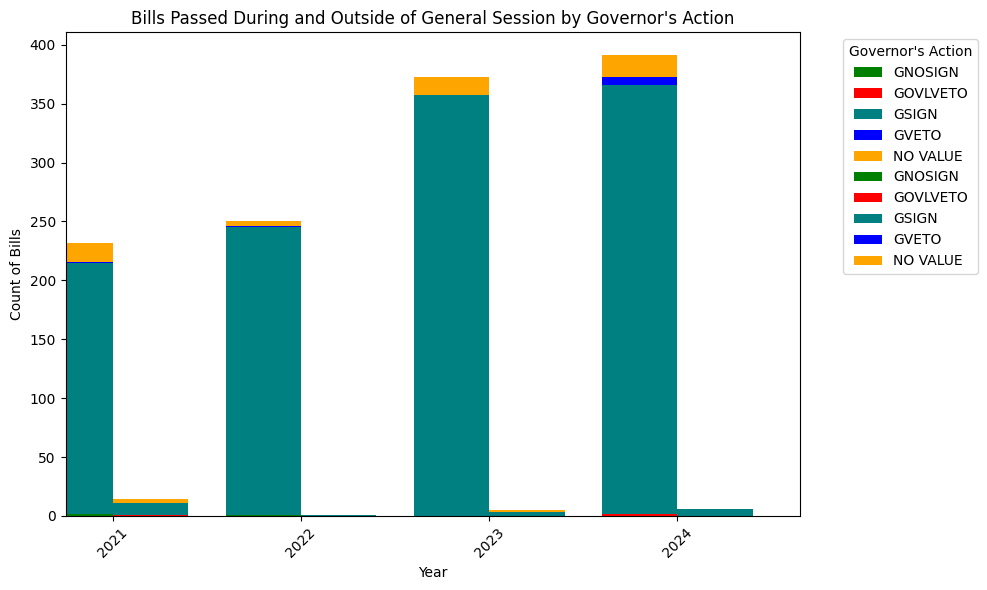

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year, Session Status, and Governor's Action, then count the occurrences
grouped = (
    merged_df.groupby(['Year', 'Session Status', 'Governor\'s Action'])
    .size()
    .unstack(fill_value=0)
)

# Separate the data into 'During Session' and 'Outside Session'
during_session = grouped.xs('During Session', level='Session Status')
outside_session = grouped.xs('Outside Session', level='Session Status')

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked bars for 'During Session'
during_session.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    position=1,
    width=0.4,
    color=['green', 'red', 'teal', 'blue', 'orange', 'purple'],
    label='_During Session'
)

# Plot the stacked bars for 'Outside Session'
outside_session.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    position=0,
    width=0.4,
    color=['green', 'red', 'teal', 'blue', 'orange', 'purple'],
    label='_Outside Session'
)

# Customizing the chart
ax.set_title('Bills Passed During and Outside of General Session by Governor\'s Action')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Bills')
ax.legend(title='Governor\'s Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


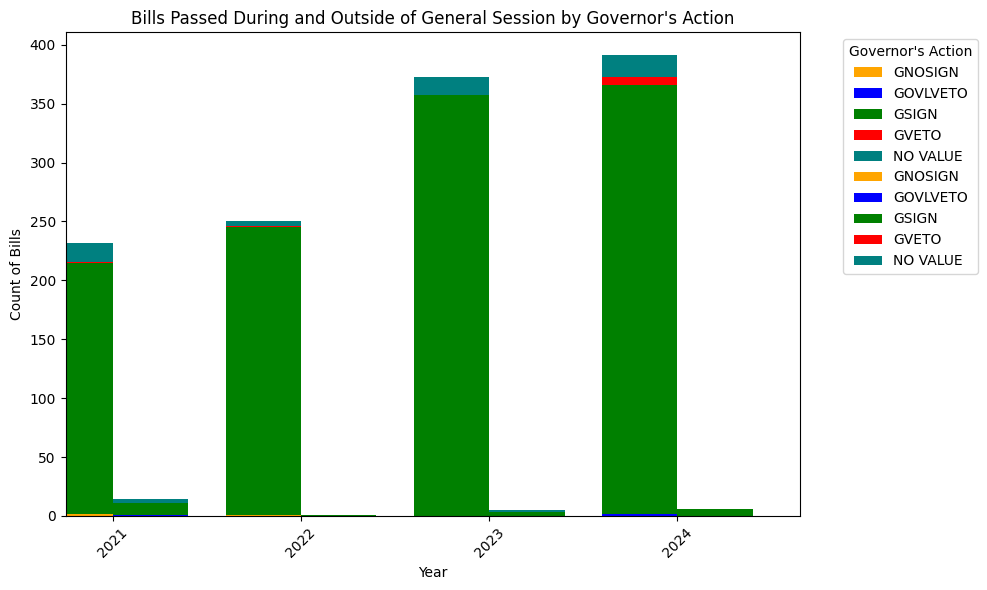

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the color map
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}

# Group by Year, Session Status, and Governor's Action, then count the occurrences
grouped = (
    merged_df.groupby(['Year', 'Session Status', 'Governor\'s Action'])
    .size()
    .unstack(fill_value=0)
)

# Separate the data into 'During Session' and 'Outside Session'
during_session = grouped.xs('During Session', level='Session Status')
outside_session = grouped.xs('Outside Session', level='Session Status')

# Ensure columns for both datasets are the same for alignment in the plot
for action in set(during_session.columns).union(set(outside_session.columns)):
    if action not in during_session:
        during_session[action] = 0
    if action not in outside_session:
        outside_session[action] = 0

# Sort columns to maintain a consistent order
during_session = during_session.sort_index(axis=1)
outside_session = outside_session.sort_index(axis=1)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Use the color map for the colors in the plot
colors = [color_map.get(action, 'gray') for action in during_session.columns]

# Plot the stacked bars for 'During Session'
during_session.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    position=1,
    width=0.4,
    color=colors,
    label='_During Session'
)

# Plot the stacked bars for 'Outside Session'
outside_session.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    position=0,
    width=0.4,
    color=colors,
    label='_Outside Session'
)

# Customizing the chart
ax.set_title('Bills Passed During and Outside of General Session by Governor\'s Action')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Bills')
ax.legend(title='Governor\'s Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [70]:
def stacked_bar_chart_gov_actions(df, name_on_ballot, color_map, print_info=False, save_chart=False, show_chart=False):
    import matplotlib.pyplot as plt

    # Check if there is data for the candidate
    if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
        print(f"No data found for {name_on_ballot}")
        return

    if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
        print(f"No bills found for {name_on_ballot}")
        return

    candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
    candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
    display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
    total_bills = len(candidate_bills)
    office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

    # Group by Year, Session Status, and Governor's Action, then count the occurrences
    grouped = (
        candidate_bills.groupby(['Year', 'Session Status', 'Governor\'s Action']).size().unstack(fill_value=0)
    )

    # Separate the data into 'During Session' and 'Outside Session' if they exist
    try:
        during_session = grouped.xs('During Session', level='Session Status', drop_level=True)
    except KeyError:
        during_session = pd.DataFrame()

    try:
        outside_session = grouped.xs('Outside Session', level='Session Status', drop_level=True)
    except KeyError:
        outside_session = pd.DataFrame()
    # Ensure columns for both datasets are the same for alignment in the plot
    for action in set(during_session.columns).union(set(outside_session.columns)):
        if action not in during_session:
            during_session[action] = 0
        if action not in outside_session:
            outside_session[action] = 0

    # Sort columns to maintain a consistent order
    during_session = during_session.sort_index(axis=1)
    outside_session = outside_session.sort_index(axis=1)

    # Sort the index to make sure 'Year' is in order
    during_session = during_session.sort_index()
    outside_session = outside_session.sort_index()

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Use the color map for the colors in the plot
    colors = [color_map.get(action, 'gray') for action in during_session.columns]

    # Plot the stacked bars for 'During Session'
    if not during_session.empty:
        during_session.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            position=1,
            width=0.4,
            color=colors,
            label='_During Session'
        )

    # Plot the stacked bars for 'Outside Session'
    if not outside_session.empty:
        outside_session.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            position=0,
            width=0.4,
            color=colors,
            label='_Outside Session'
        )

    # Customizing the chart
    ax.set_title(f"Stacked Bar Chart of Bills Sponsored by {candidate_name} Passed During and Outside of the General Session by Governor\'s Action\n"
                 f"{office} {display_district}\n"
                 f"Total number of bills sponsored = {total_bills}", fontsize=14)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count of Bills')
    ax.legend(title='Governor\'s Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(range(len(during_session.index)))
    ax.set_xticklabels(during_session.index, rotation=45)
    plt.tight_layout()

    if print_info:
        print(f"Stacked Bar Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

    if save_chart:
        save_candidate_chart(fig, office, candidate_name, "word_cloud", base_drive_path)

    if show_chart:
        plt.show()
    else:
        plt.close(fig)


In [72]:
merged_df['Name on Ballot'].unique()[3]

'WAYNE A HARPER'

In [69]:
name_on_ballot = 'LUZ ESCAMILLA'
candidate_bills = merged_df[merged_df['Name on Ballot'] == name_on_ballot]
candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
total_bills = len(candidate_bills)
office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"
# print(candidate_bills)
# print(candidate_name)
# print(display_district)
# print(total_bills)
# print(office)
grouped = (
    candidate_bills.groupby(['Year', 'Session Status', 'Governor\'s Action']).size().unstack(fill_value=0)
)

# Separate the data into 'During Session' and 'Outside Session' if they exist
# Separate the data into 'During Session' and 'Outside Session'
try:
    during_session = grouped.xs('During Session', level='Session Status', drop_level=True)
except KeyError:
    during_session = pd.DataFrame()

try:
    outside_session = grouped.xs('Outside Session', level='Session Status', drop_level=True)
except KeyError:
    outside_session = pd.DataFrame()
print('grouped: ', grouped)
print('during session', during_session)
print('outside session', outside_session)

grouped:  Governor's Action    GSIGN
Year Session Status       
2021 During Session      5
2022 During Session      6
2023 During Session      5
2024 During Session      5
during session Governor's Action  GSIGN
Year                    
2021                   5
2022                   6
2023                   5
2024                   5
outside session Empty DataFrame
Columns: []
Index: []


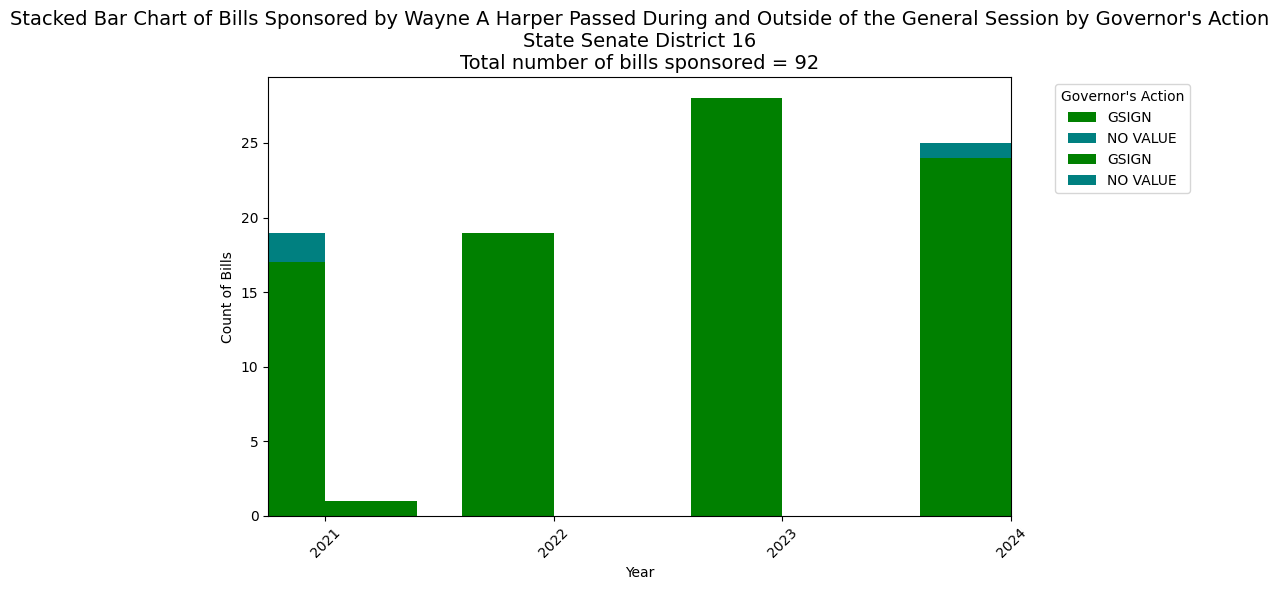

In [73]:
candidate = 'WAYNE A HARPER'
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}

stacked_bar_chart_gov_actions(df=merged_df,
                              name_on_ballot=candidate,
                              color_map=color_map,
                              print_info=False,
                              save_chart=False,
                              show_chart=True)


In [60]:
merged_df.loc[merged_df['Name on Ballot'] == candidate]

,Name on Ballot,First Name,Middle Name,Last Name_x,Office,District,Party,Status,Display District,record_id,...,Governor's Action,Gov's Action Date,Laws of Utah Chapter,sheet_name,Year,Last Name_y,First Initial_y,Sponsor Key,Category,Session Status
0,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2023-03-21,452.0,passedBills_2023_general_session.csv,2023,Escamilla,L,Escamilla L,Other,During Session
1,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2023-03-15,317.0,passedBills_2023_general_session.csv,2023,Escamilla,L,Escamilla L,Healthcare,During Session
2,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2023-03-15,322.0,passedBills_2023_general_session.csv,2023,Escamilla,L,Escamilla L,Other,During Session
3,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2023-03-15,332.0,passedBills_2023_general_session.csv,2023,Escamilla,L,Escamilla L,Healthcare,During Session
4,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2023-03-23,513.0,passedBills_2023_general_session.csv,2023,Escamilla,L,Escamilla L,Other,During Session
5,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2022-03-23,241.0,passedBills_2022_general_session.csv,2022,Escamilla,L,Escamilla L,Other,During Session
6,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2022-03-23,279.0,passedBills_2022_general_session.csv,2022,Escamilla,L,Escamilla L,Education,During Session
7,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2022-03-21,94.0,passedBills_2022_general_session.csv,2022,Escamilla,L,Escamilla L,Agriculture & Food,During Session
8,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2022-03-21,95.0,passedBills_2022_general_session.csv,2022,Escamilla,L,Escamilla L,Government & Administration,During Session
9,LUZ ESCAMILLA,Luz,NaN,Escamilla,State Senate,10,DEMOCRATIC,Election Candidate,District 10,LUZ-STATE SENATE-10,...,GSIGN,2022-03-24,452.0,passedBills_2022_general_session.csv,2022,Escamilla,L,Escamilla L,Healthcare,During Session


*****************************
Looping through State House
*****************************
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
No bills found for MATT MACPHERSON
*****************************
Looping through State Senate
*****************************


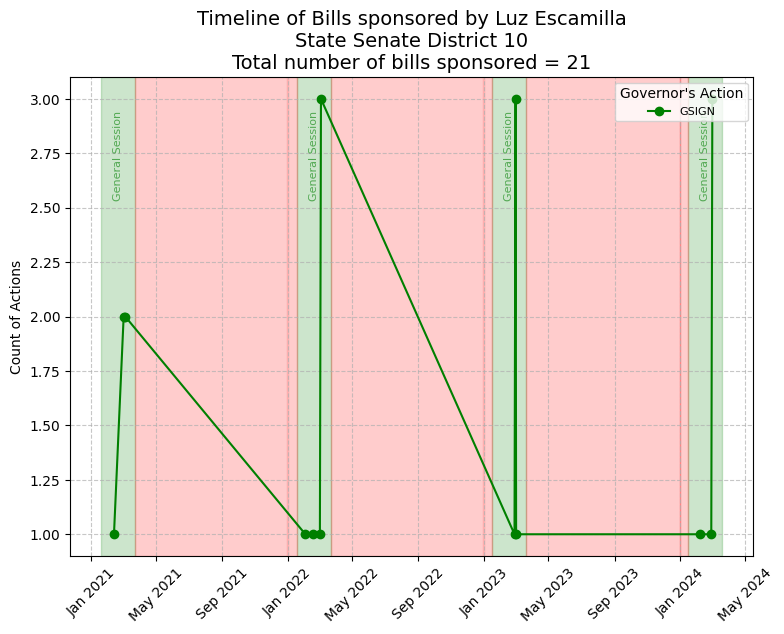

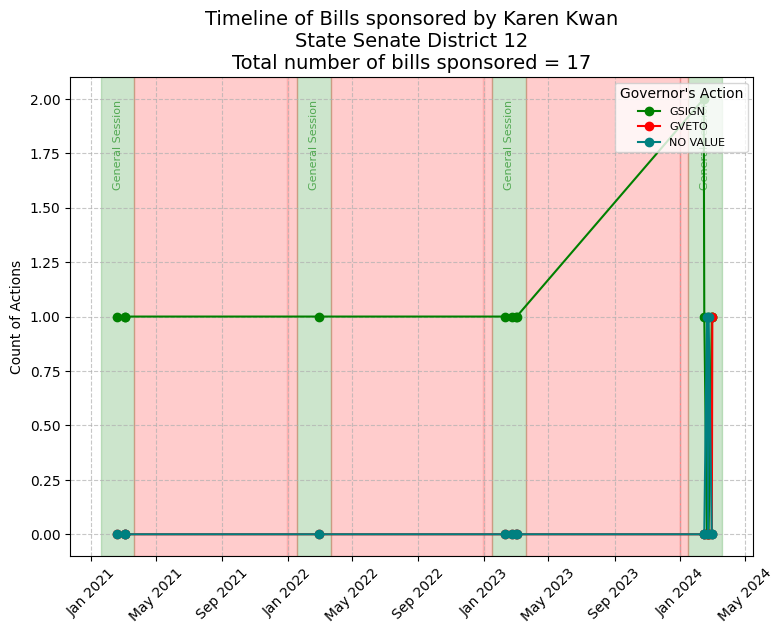

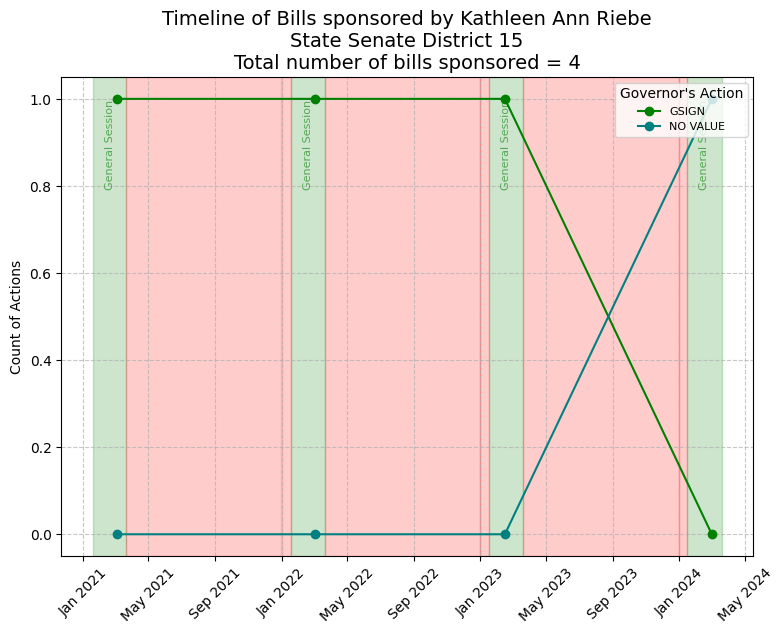

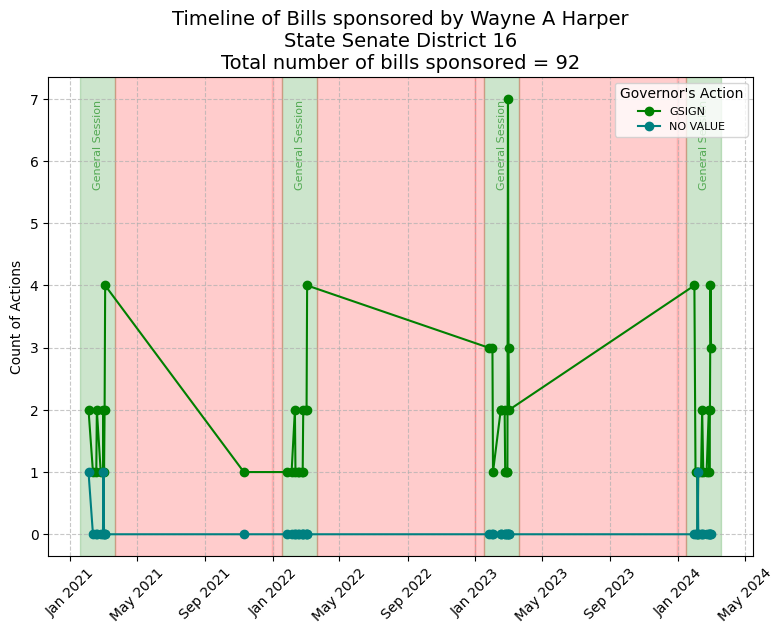

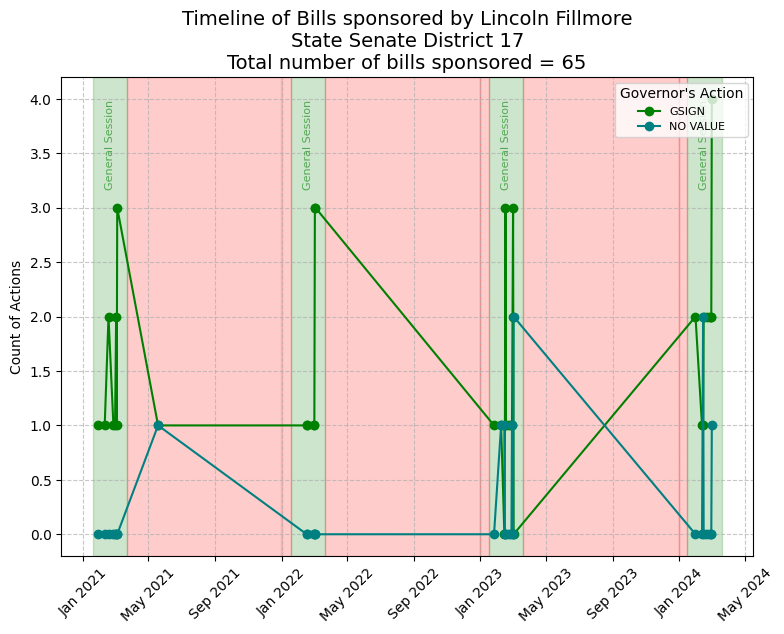

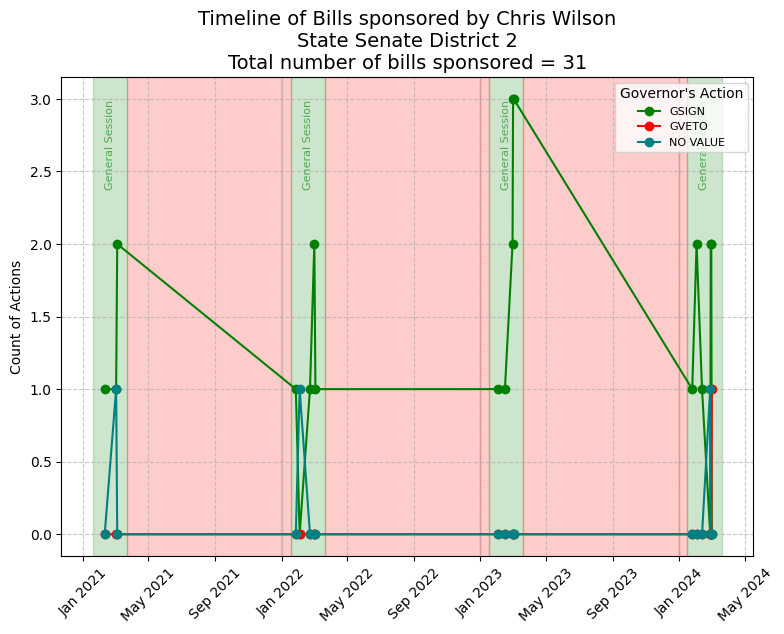

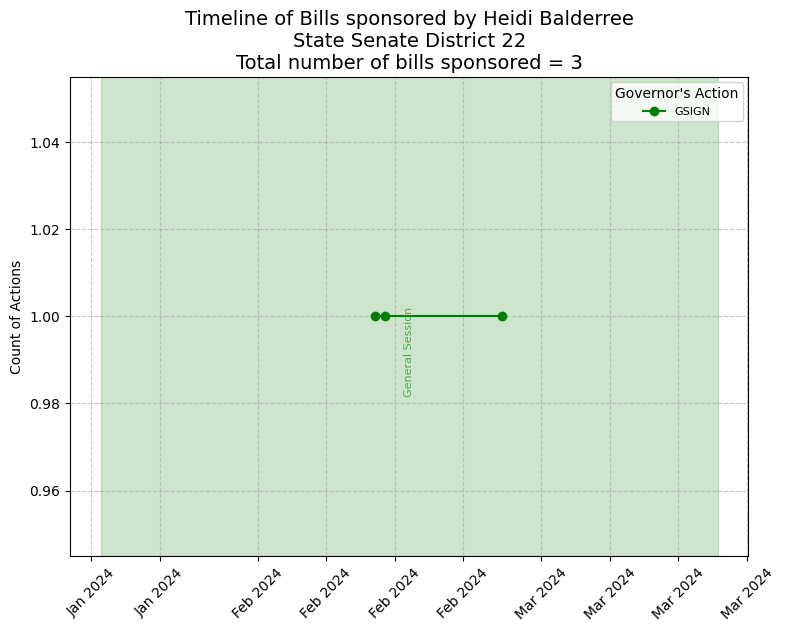

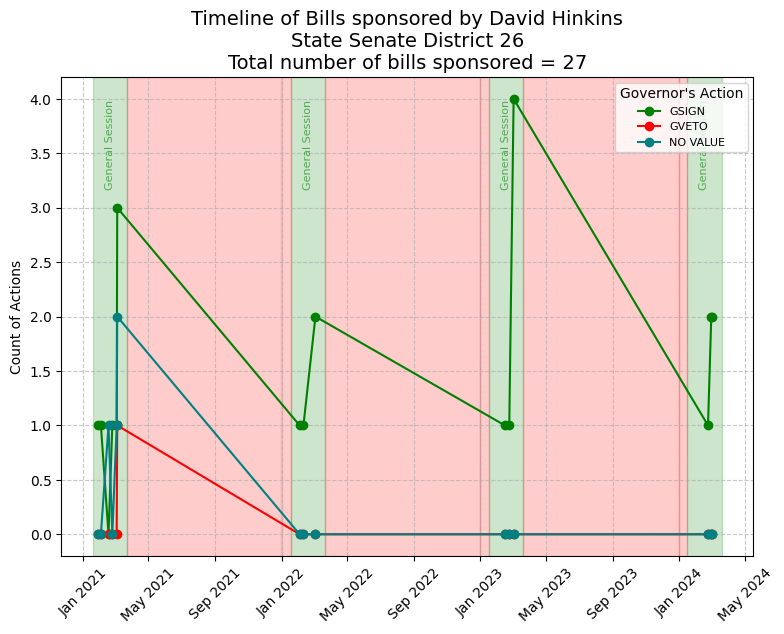

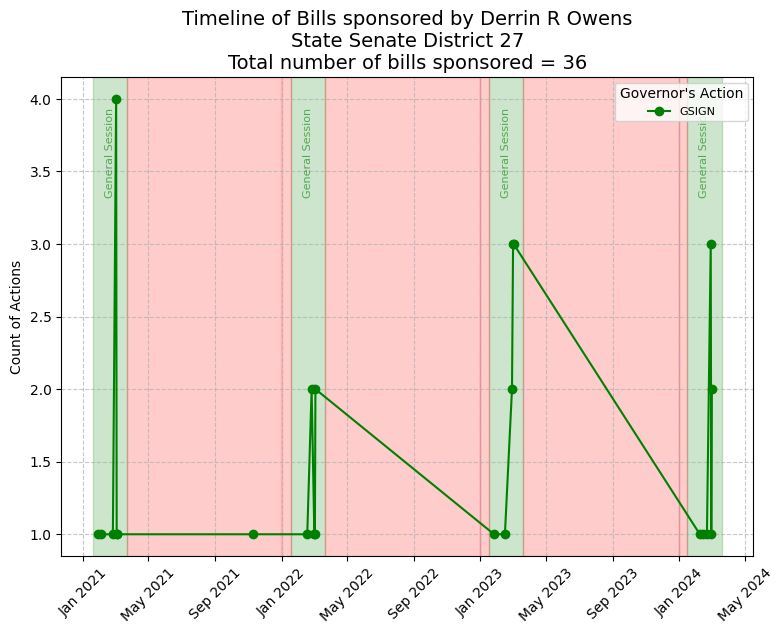

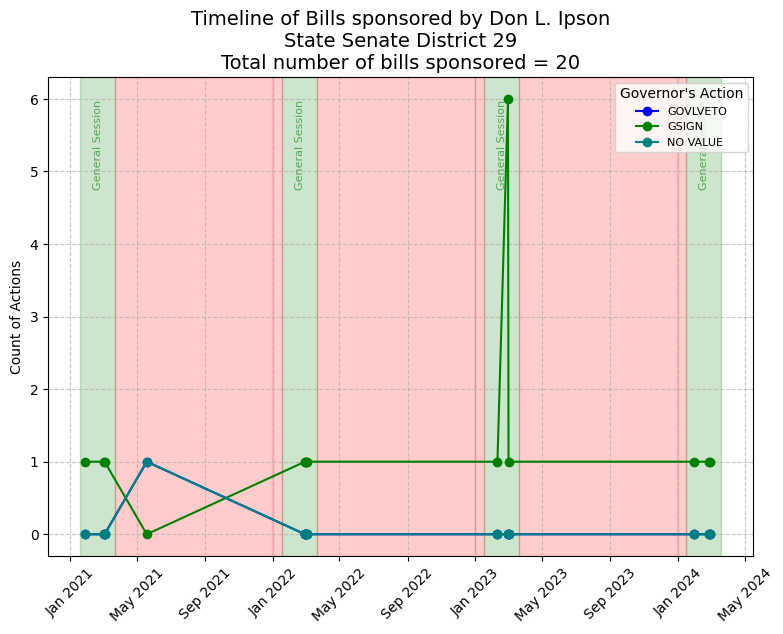

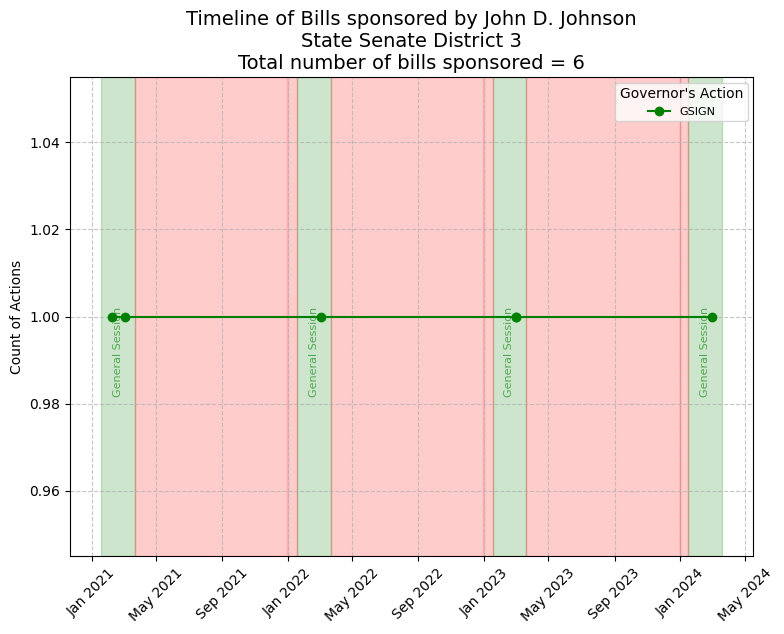

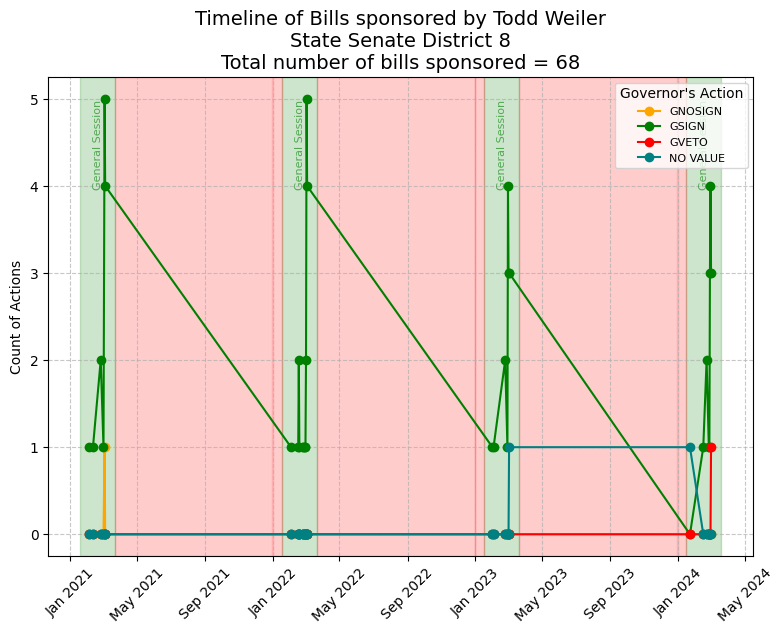

In [31]:
# Now we have the cahrts, lets save the data to a drive so we can use those charts to create a website

# bar chart and timline colors
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}
# category treemap colors
treemap_colormap = {
    'Healthcare': '#FFB11C',
    'Education': '#FF6100',
    'Agriculture & Food': '#85EA00',
    'Government & Administration': '#85EAA8',
    'Environment': '#165EA8',
    'Housing': '#165E65',
    'Technology & Innovation': '#601565',
    'Transportation': '#001565',
    'Economy & Business': '#0015FF',
    'Civil Rights & Justice': '#7DFF74',
    'Military & Defense': '#FFFF7F',
    'Energy': '#FF7AFF',
    'Other': '#402100'
}
# word cloud customization
wordcloud_colors = 'tab20c'
limit_cloud_words = 30
# folder to save charts to
base_drive_path = '/content/drive/My Drive/ut_pol/bill_charts'

# ########### #
# STATE HOUSE #
# ########### #
print('*****************************\nLooping through State House\n*****************************')
state_house = merged_df.loc[merged_df['Office'] == 'State House']

for candidate in state_house['Name on Ballot'].unique():
  # Bar Chart #
  bar_chart_gov_actions(df=state_house,
                      name_on_ballot=candidate,
                      color_map=color_map,
                      print_info=False,
                      save_chart=False,
                      show_chart=False)
  # Timeline #
  timeline_gov_actions(df=state_house,
                       name_on_ballot=candidate,
                       color_map=color_map,
                       print_info=False,
                       save_chart=False,
                       show_chart=False)
  # Treemap #
  treemap_bill_categories(df=state_house,
                        name_on_ballot=candidate,
                        color_map=treemap_colormap,
                        print_info=False,
                        save_chart=False,
                        show_chart=False)
  # Wordcloud #
  wordcloud_bill_titles(df=state_house,
                        name_on_ballot=candidate,
                        color_map=wordcloud_colors,
                        num_words=limit_cloud_words,
                        base_drive_path=base_drive_path,
                        show_chart=False,
                        print_info=False,
                        save_chart=False)

# ############ #
# STATE SENATE #
# ############ #

print('*****************************\nLooping through State Senate\n*****************************')
state_senate = merged_df.loc[merged_df['Office'] == 'State Senate']

for candidate in state_senate['Name on Ballot'].unique():
  # Bar Chart #
  bar_chart_gov_actions(df=state_senate,
                        name_on_ballot=candidate,
                        color_map=color_map,
                        print_info=False,
                        save_chart=False,
                        show_chart=False)
  # Timeline #
  timeline_gov_actions(df=state_senate,
                       name_on_ballot=candidate,
                       color_map=color_map,
                       print_info=False,
                       save_chart=False,
                       show_chart=True)
  # Treemap #
  treemap_bill_categories(df=state_senate,
                          name_on_ballot=candidate,
                          color_map=treemap_colormap,
                          print_info=False,
                          save_chart=False,
                          show_chart=False)
  # # Wordcloud #
  wordcloud_bill_titles(df=state_senate,
                      name_on_ballot=candidate,
                      color_map=wordcloud_colors,
                      num_words=limit_cloud_words,
                      base_drive_path=base_drive_path,
                      show_chart=False,
                      print_info=False,
                      save_chart=False)

*****************************
Looping through State House
*****************************


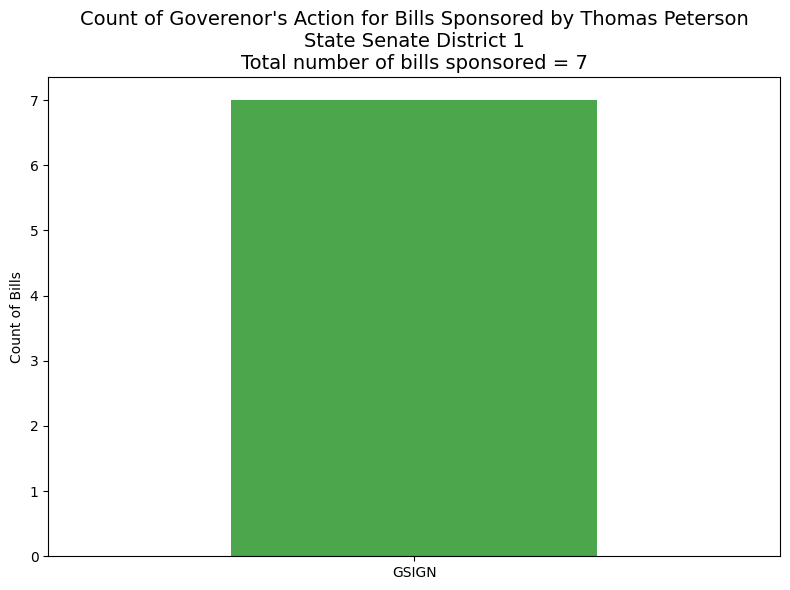

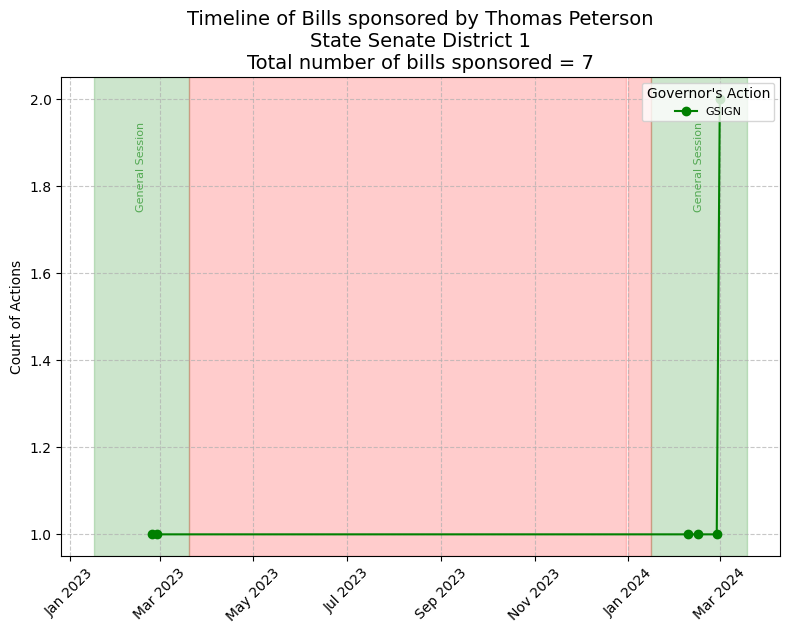

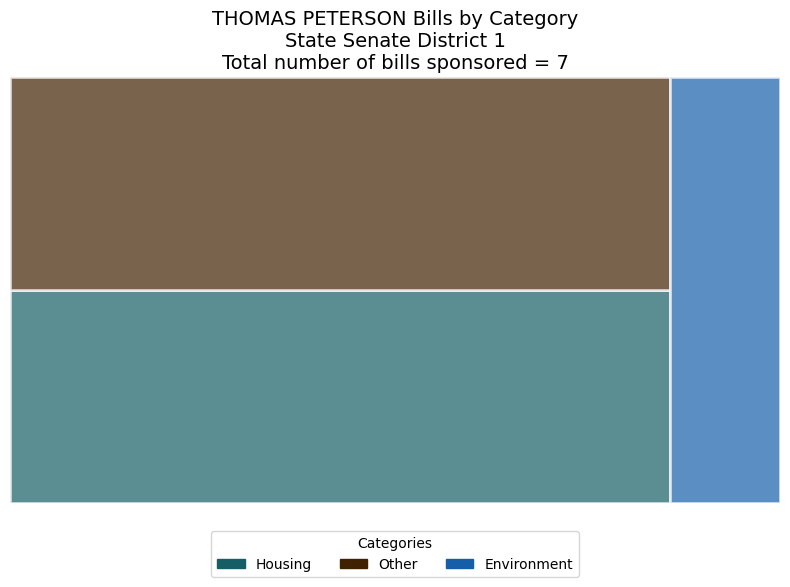

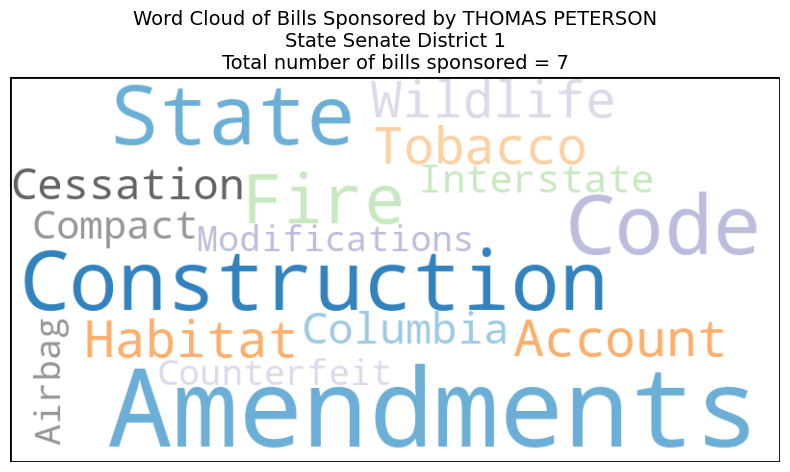

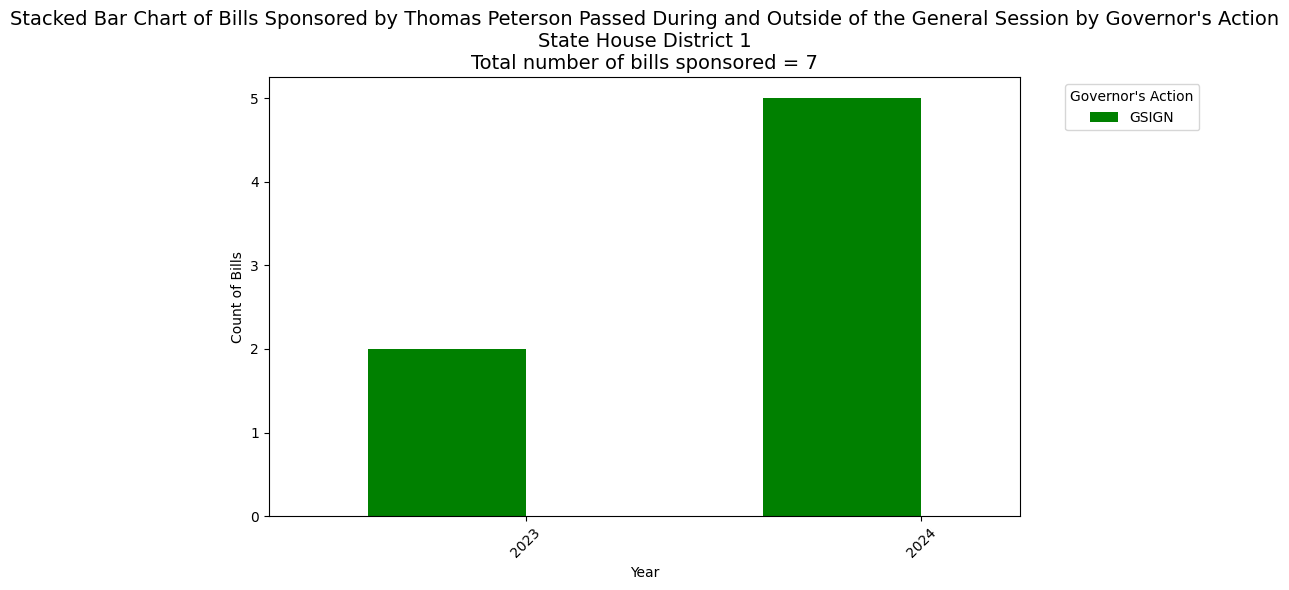

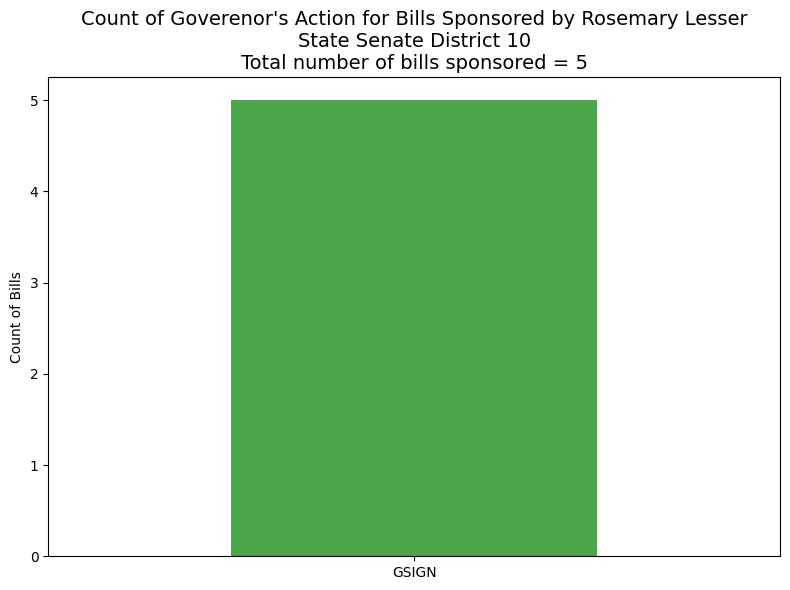

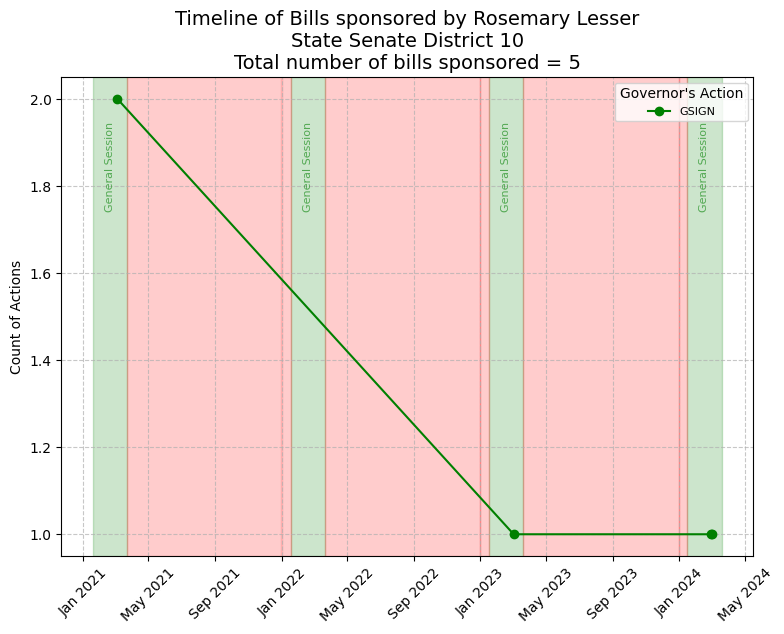

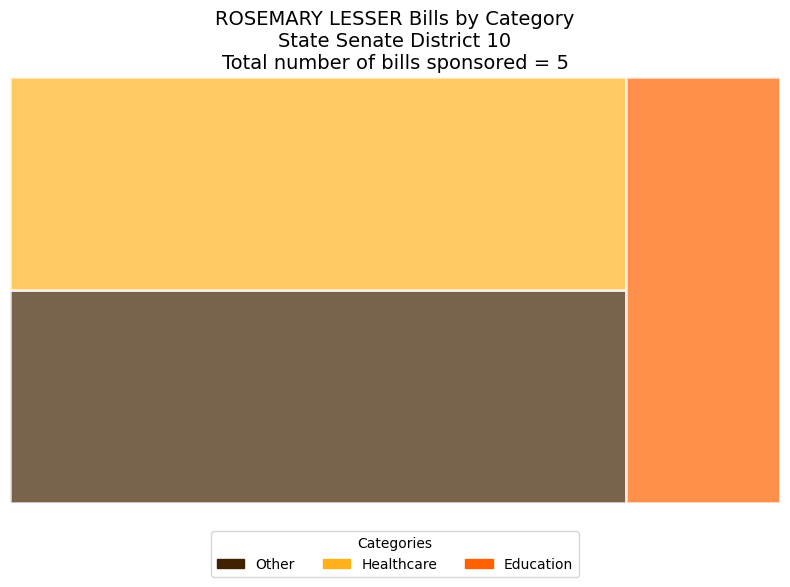

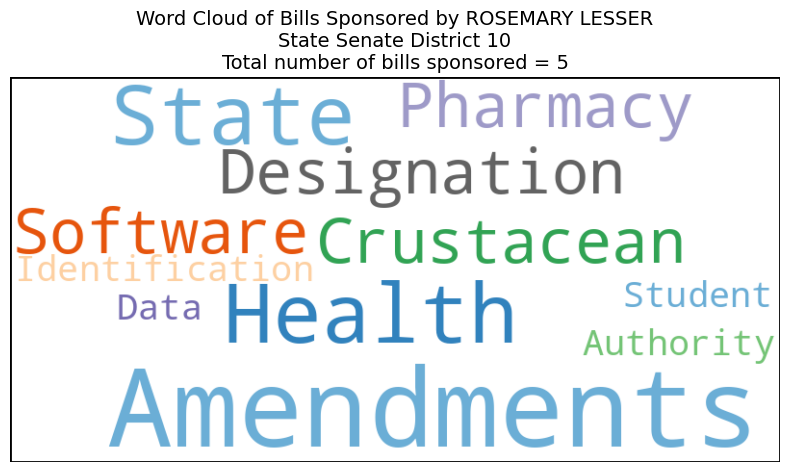

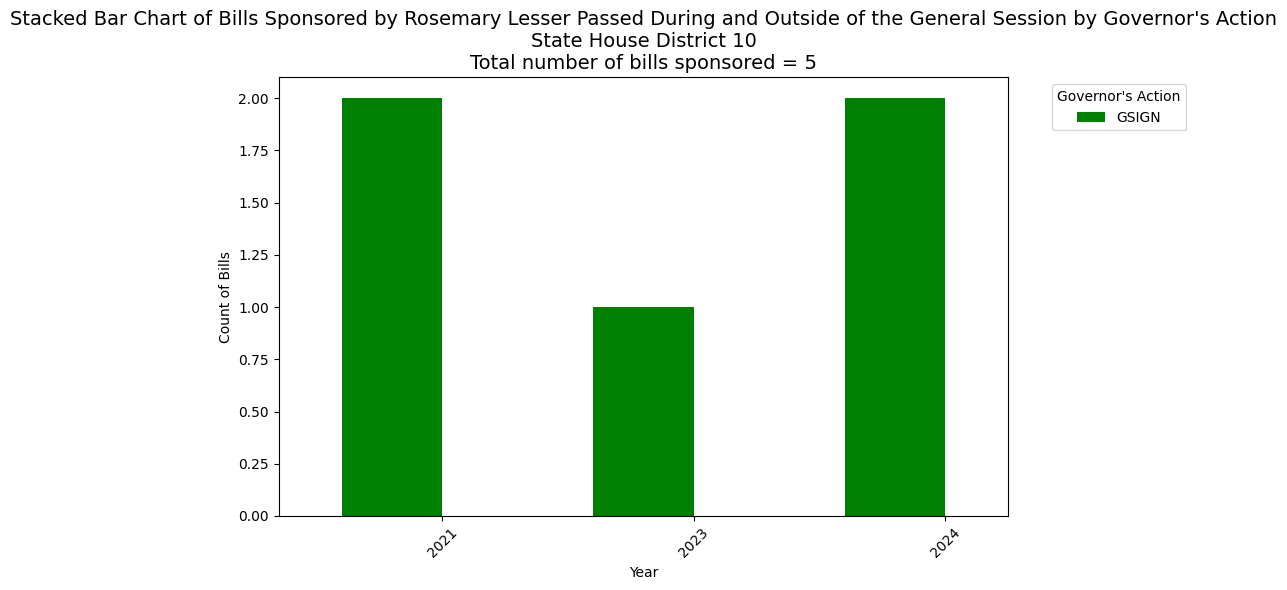

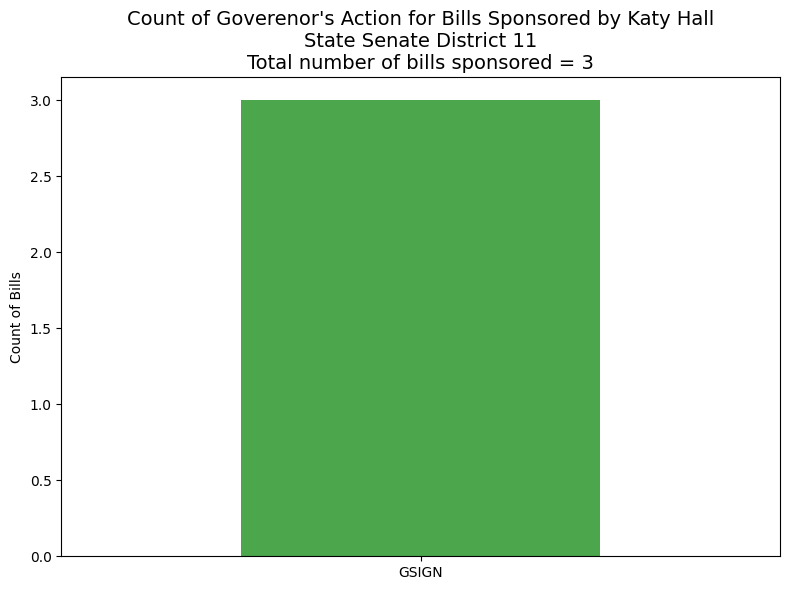

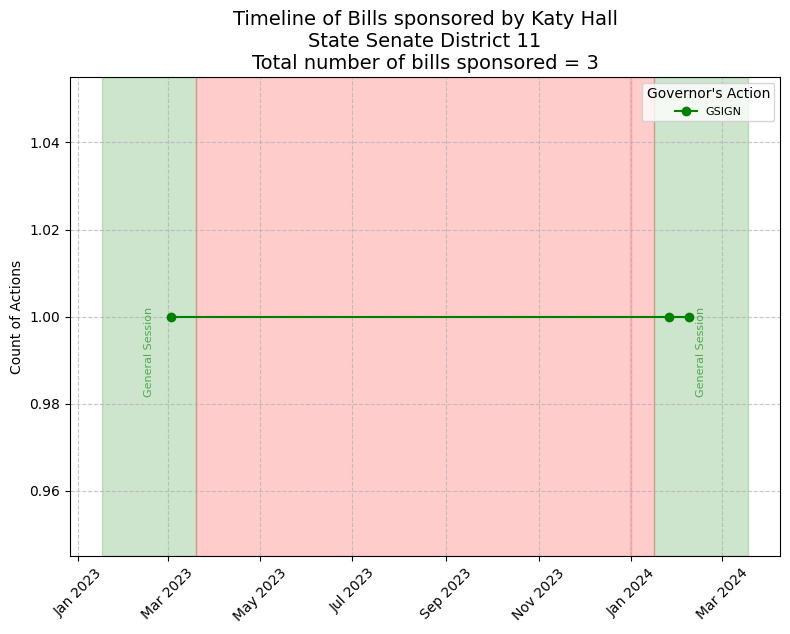

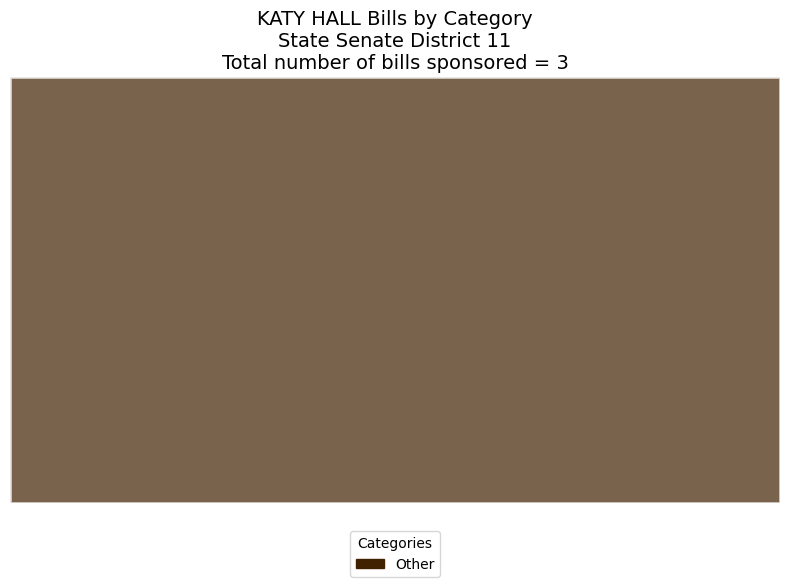

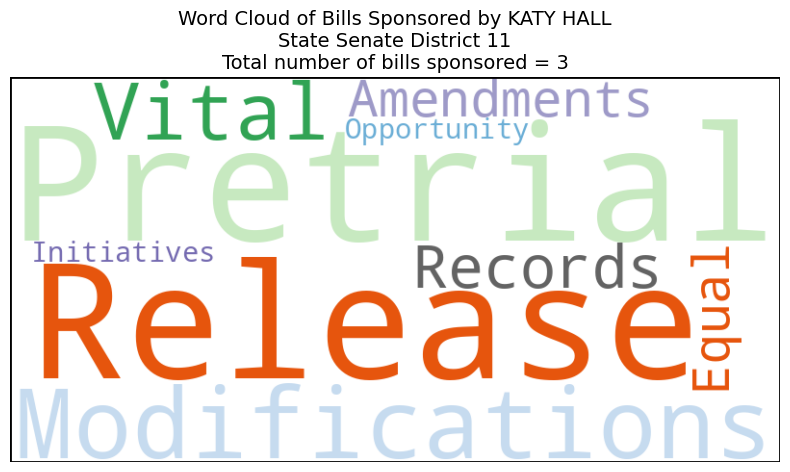

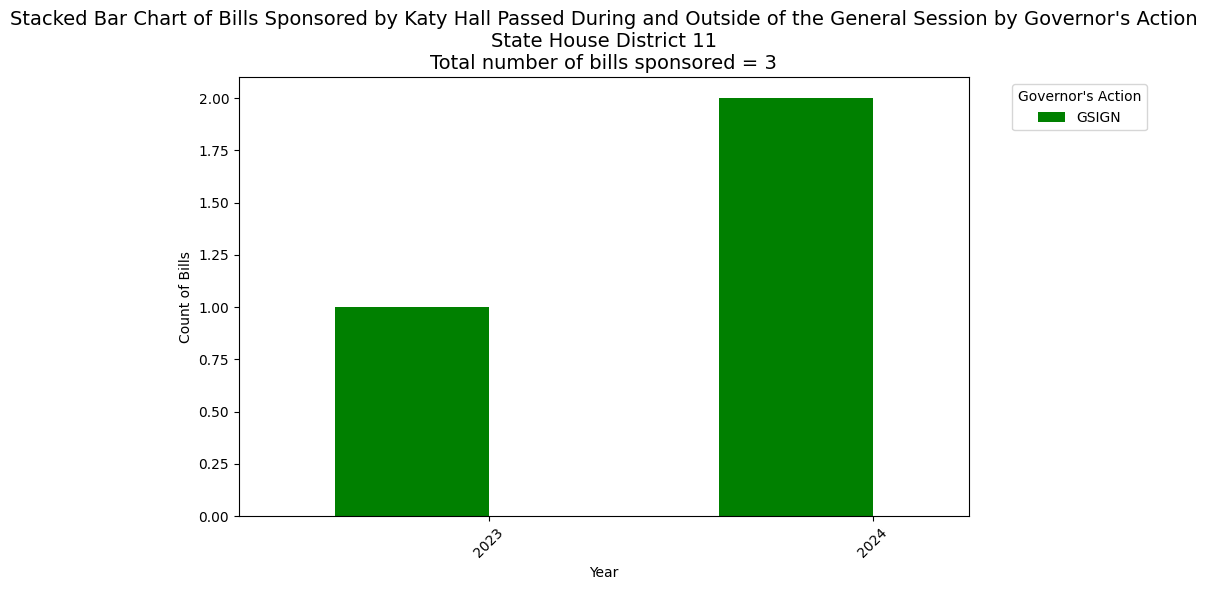

In [77]:
# Existing color maps and settings
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}

# Category treemap colors
treemap_colormap = {
    'Healthcare': '#FFB11C',
    'Education': '#FF6100',
    'Agriculture & Food': '#85EA00',
    'Government & Administration': '#85EAA8',
    'Environment': '#165EA8',
    'Housing': '#165E65',
    'Technology & Innovation': '#601565',
    'Transportation': '#001565',
    'Economy & Business': '#0015FF',
    'Civil Rights & Justice': '#7DFF74',
    'Military & Defense': '#FFFF7F',
    'Energy': '#FF7AFF',
    'Other': '#402100'
}

# Word cloud customization
wordcloud_colors = 'tab20c'
limit_cloud_words = 30
# Folder to save charts to
base_drive_path = '/content/drive/My Drive/ut_pol/bill_charts'

# ########### #
# STATE HOUSE #
# ########### #
print('*****************************\nLooping through State House\n*****************************')
state_house = merged_df.loc[merged_df['Office'] == 'State House']

count = 3
for candidate in state_house['Name on Ballot'].unique():
    # Filter bills for the current candidate
    candidate_bills = state_house[state_house['Name on Ballot'] == candidate]

    # Bar Chart #
    bar_chart_gov_actions(df=candidate_bills,
                          name_on_ballot=candidate,
                          color_map=color_map,
                          print_info=False,
                          save_chart=False,
                          show_chart=True)

    # Timeline #
    timeline_gov_actions(df=candidate_bills,
                         name_on_ballot=candidate,
                         color_map=color_map,
                         print_info=False,
                         save_chart=False,
                         show_chart=True)

    # Treemap #
    treemap_bill_categories(df=candidate_bills,
                            name_on_ballot=candidate,
                            color_map=treemap_colormap,
                            print_info=False,
                            save_chart=False,
                            show_chart=True)

    # Wordcloud #
    wordcloud_bill_titles(df=candidate_bills,
                          name_on_ballot=candidate,
                          color_map=wordcloud_colors,
                          num_words=limit_cloud_words,
                          base_drive_path=base_drive_path,
                          show_chart=True,
                          print_info=False,
                          save_chart=False)
    # stacked bar chart
    stacked_bar_chart_gov_actions(df=merged_df,
                              name_on_ballot=candidate,
                              color_map=color_map,
                              print_info=False,
                              save_chart=False,
                              show_chart=True)

    count = count -1
    if count == 0:
      break
